In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import pandas as pd
import numpy as np
import math
import datetime as dt
import seaborn as sns  
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [14]:
import yfinance as yf


yf.pdr_override()

# For time stamps
import yfinance as yf

# end date data is excluded 
data = yf.download('RELIANCE.NS', start='2011-01-03', end='2021-06-15')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,486.882172,487.567932,481.213318,482.584808,435.470520,5205628
2011-01-04,484.596344,493.693939,483.362000,492.413879,444.340057,11010939
2011-01-05,493.739655,498.311340,489.167999,491.819580,443.803711,12971621
2011-01-06,492.825348,498.951355,491.248108,496.299805,447.846588,10881590
2011-01-07,494.333984,497.282715,483.682007,487.065033,439.513367,8937553
...,...,...,...,...,...,...
2021-06-08,2055.151123,2055.658691,2028.891724,2044.075073,2023.202271,4837367
2021-06-09,2048.136230,2049.982178,1991.787109,2007.524292,1987.024780,5704580
2021-06-10,2024.507446,2058.289307,2009.877930,2014.908325,1994.333374,7077826


In [19]:
pip install torch

   ---------------------------------------- 0.0/198.5 MB ? eta -:--:--
   ---------------------------------------- 0.2/198.5 MB 5.0 MB/s eta 0:00:41
   ---------------------------------------- 0.4/198.5 MB 3.8 MB/s eta 0:00:52
   ---------------------------------------- 0.7/198.5 MB 4.7 MB/s eta 0:00:42
   ---------------------------------------- 1.4/198.5 MB 7.6 MB/s eta 0:00:26
   ---------------------------------------- 2.0/198.5 MB 8.4 MB/s eta 0:00:24
    --------------------------------------- 2.5/198.5 MB 9.0 MB/s eta 0:00:22
    --------------------------------------- 3.1/198.5 MB 9.5 MB/s eta 0:00:21
    --------------------------------------- 3.7/198.5 MB 9.7 MB/s eta 0:00:20
    --------------------------------------- 4.2/198.5 MB 10.0 MB/s eta 0:00:20
    --------------------------------------- 4.8/198.5 MB 10.2 MB/s eta 0:00:19
   - -------------------------------------- 5.4/198.5 MB 10.4 MB/s eta 0:00:19
   - -------------------------------------- 5.9/198.5 MB 10.5 MB/s e

In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [22]:
data['y'] = data['Close']

x = data.iloc[:, :6].values
y = data.iloc[:, 6].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))
     

trainX: (2058, 6) trainY: (2058,)
testX: (515, 6) testY: (515,)


In [27]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar
     

In [30]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([6, 400, 400, 400, 10], 10)
     

[1/300] Loss: 269.9727107286453
[2/300] Loss: 230.1867117881775
[3/300] Loss: 196.8094757795334
[4/300] Loss: 181.37162804603577
[5/300] Loss: 187.54122018814087
[6/300] Loss: 193.15454626083374
[7/300] Loss: 180.15462636947632
[8/300] Loss: 162.3154320716858
[9/300] Loss: 155.9178967475891
[10/300] Loss: 158.97163653373718
[11/300] Loss: 164.39331901073456
[12/300] Loss: 165.81208515167236
[13/300] Loss: 160.98122119903564
[14/300] Loss: 151.58628845214844
[15/300] Loss: 141.7517068386078
[16/300] Loss: 136.24060153961182
[17/300] Loss: 140.15437984466553
[18/300] Loss: 148.4812741279602
[19/300] Loss: 148.32482361793518
[20/300] Loss: 138.26180458068848
[21/300] Loss: 126.57304835319519
[22/300] Loss: 120.92320704460144
[23/300] Loss: 121.63495779037476
[24/300] Loss: 125.04469525814056
[25/300] Loss: 127.90930461883545
[26/300] Loss: 128.1348693370819
[27/300] Loss: 125.30733048915863
[28/300] Loss: 119.7253806591034
[29/300] Loss: 112.35817098617554
[30/300] Loss: 105.2555775642395

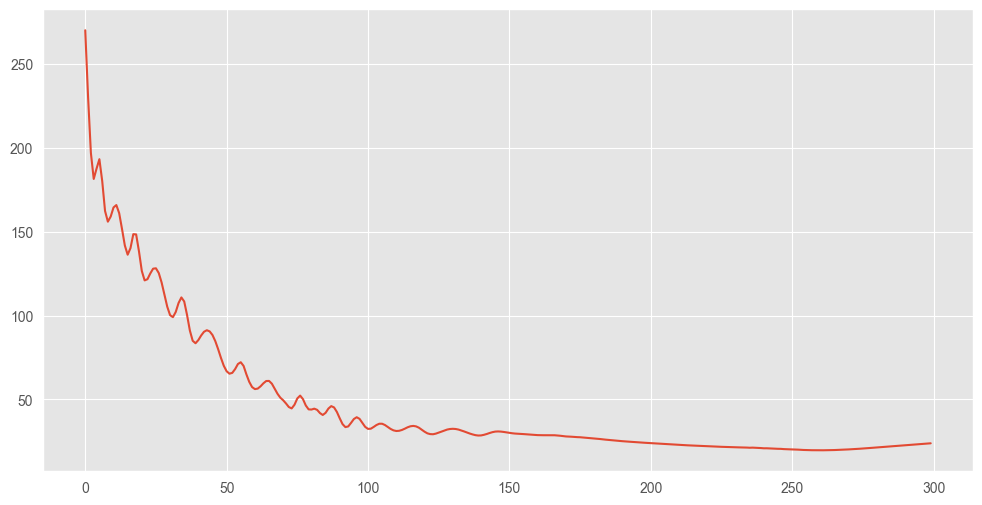

In [31]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)
     

In [32]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [33]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [34]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)
     


In [35]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2055, 3, 16]) train_y: torch.Size([2055, 1]) train_y_gan: torch.Size([2055, 4, 1])
test_x: torch.Size([512, 3, 16]) test_y: torch.Size([512, 1]) test_y_gan: torch.Size([512, 4, 1])


In [36]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [38]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(16).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/165] LossD: 23.56848430633545 LossG:11.688723266124725
[2/165] LossD: 23.566190123558044 LossG:11.785833954811096
[3/165] LossD: 23.567381620407104 LossG:11.784187376499176
[4/165] LossD: 23.5642147064209 LossG:11.78789496421814
[5/165] LossD: 23.568022966384888 LossG:11.785097539424896
[6/165] LossD: 23.56683313846588 LossG:11.782722890377045
[7/165] LossD: 23.566980361938477 LossG:11.783504128456116
[8/165] LossD: 23.566920161247253 LossG:11.783816754817963
[9/165] LossD: 23.56695306301117 LossG:11.783655762672424
[10/165] LossD: 23.566891074180603 LossG:11.782638251781464
[11/165] LossD: 23.566816926002502 LossG:11.782981216907501
[12/165] LossD: 23.566970705986023 LossG:11.781003475189209
[13/165] LossD: 23.566749334335327 LossG:11.784014523029327
[14/165] LossD: 23.566824197769165 LossG:11.783217906951904
[15/165] LossD: 23.56673288345337 LossG:11.783345639705658
[16/165] LossD: 23.56670618057251 LossG:11.783576726913452
[17/165] LossD: 23.566636323928833 LossG:11.7835533022880

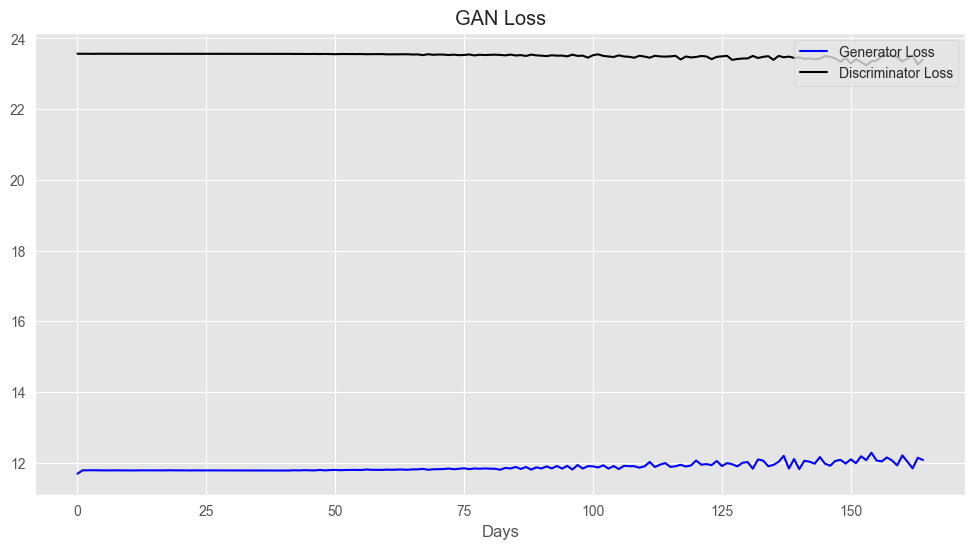

In [39]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
     

In [40]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:48.41663525456376


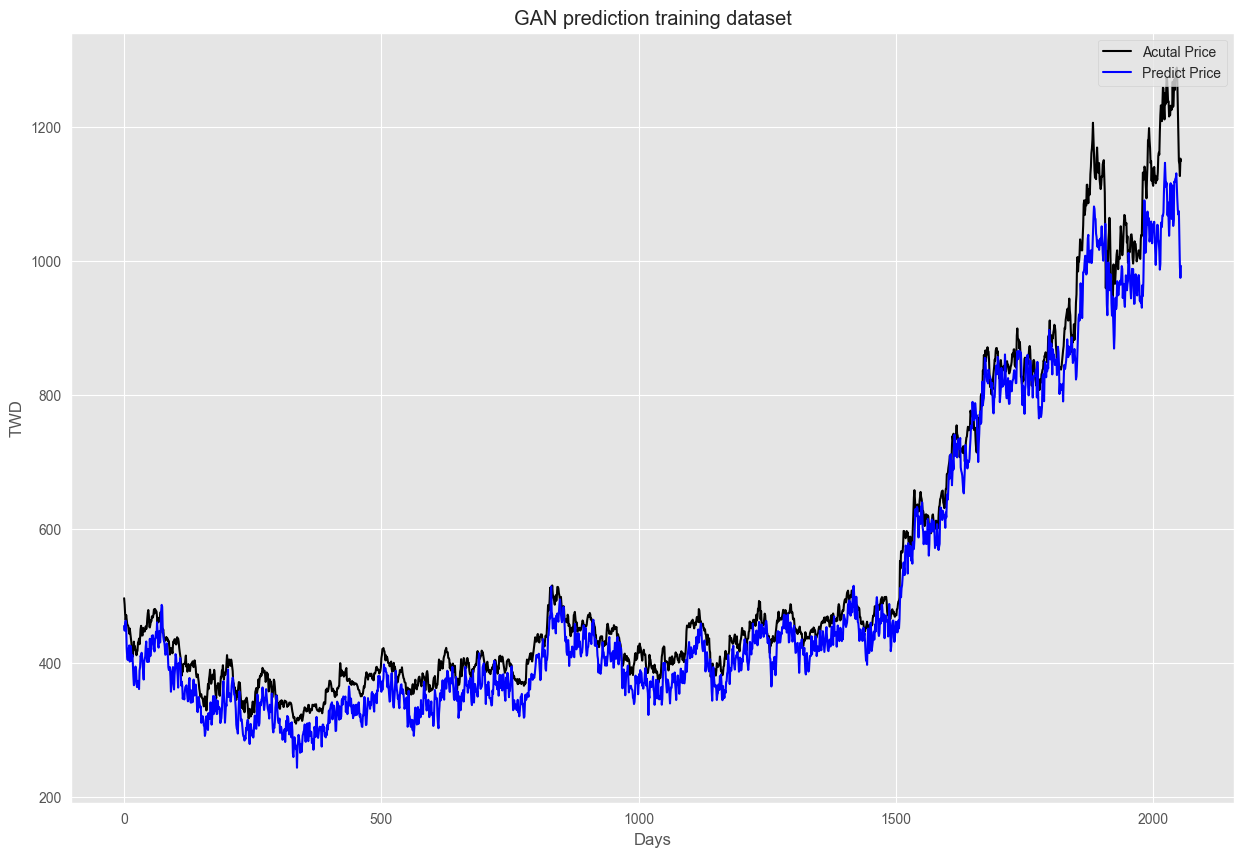

In [43]:
plt.figure(figsize=(15, 10))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')